In [32]:
import os
import sys
sys.path.append("/groups/kemi/brq616/speciale/opt/xTB/tQMC/QMC")

import logging
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors as rdMD
import hashlib
import itertools
from itertools import product
from rdkit import Chem, rdBase
import time
from tqdm import tqdm
from rdkit.Chem import rdchem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from qmconf import QMConf
from qmmol import QMMol
import pandas as pd
import random
import matplotlib.pyplot as plt

In [33]:
rdBase.DisableLog('rdApp.error')  # disable RDKit warning messages
# Set up logging
logging.basicConfig(level=logging.INFO)

In [34]:
def generate_molecules(base_mol, substituents, indices, max_subs, min_subs=0):
    new_mols = set()
    failed = 0
    max_possible_subs = min(max_subs, len(indices), len(substituents))
    total_subs_range = max_possible_subs + 1

    for num_subs in range(min_subs, total_subs_range):
        for subs in itertools.combinations_with_replacement(substituents, num_subs):
            for inds in itertools.combinations(indices, num_subs):
                new_mol = Chem.RWMol(base_mol)
                for (sub, sub_index, bond_type), base_index in zip(subs, inds):
                    num_atoms_new = new_mol.GetNumAtoms()
                    for atom in sub.GetAtoms():
                        new_mol.AddAtom(atom)
                    for bond in sub.GetBonds():
                        new_mol.AddBond(bond.GetBeginAtomIdx(
                        ) + num_atoms_new, bond.GetEndAtomIdx() + num_atoms_new, bond.GetBondType())
                    new_mol.AddBond(
                        base_index, num_atoms_new + sub_index, bond_type)
                try:
                    Chem.SanitizeMol(new_mol)
                    new_mols.add(new_mol)
                except:
                    failed += 1

    logging.debug(f'Failed sanitizations: {failed}')
    return new_mols


def visualize_molecule(molecule):
    if isinstance(molecule, str):
        molecule = Chem.MolFromSmiles(molecule)
    
    img = Draw.MolToImage(molecule)
    display(img)



def replace_atoms(base_smiles, atom_list, indices):
    new_mols = set()
    atom_combinations = product(atom_list, repeat=len(indices))
    
    for atom_combination in atom_combinations:
        new_smiles = base_smiles
        for idx, replacement_atom in zip(indices, atom_combination):
            new_smiles = new_smiles.replace('*', replacement_atom, 1)
        
        new_mol = Chem.MolFromSmiles(new_smiles)
        if new_mol:
            try:
                Chem.SanitizeMol(new_mol)
                new_mols.add(new_mol)
            except:
                print(f"Failed to sanitize molecule: {new_smiles}")
        else:
            print(f"Failed to create molecule: {new_smiles}")

    return new_mols


def generate_and_print_molecules(base_molecule, substituents, positions, 
                                 max_subs, ring_side, position_type):    
    all_new_molecules = set()
    logging.debug(
        f"""Generating {ring_side} ring {position_type} positions 
        with up to {max_subs} substitutions""")
    for num_subs in range(0, max_subs+1):
        new_molecules = generate_molecules(
            base_molecule, substituents, positions, num_subs)
        all_new_molecules.update(new_molecules)
    return all_new_molecules


def add_atom_numbers(molecule):
    # Add atom index property to each atom
    for atom in molecule.GetAtoms():
        atom.SetProp('molAtomMapNumber', str(atom.GetIdx()))


def validate_molecules(molecule_tuples):
    invalid_molecules = []
    for (mol, index, bond) in molecule_tuples:
        if mol is None:
            invalid_molecules.append((mol, index, bond))
    return invalid_molecules


def get_hashed_label(smiles, length=10):
    if smiles is not None:
        hashed_label = hashlib.sha1(smiles.encode()).hexdigest()[:length]
        return hashed_label
    else:
        return None

class MoleculeSet:
    def __init__(self):
        self._molecules = set()
        
    def smiles(self):
        for smiles_str in self._molecules:
            yield smiles_str
    
    def update_with_canonical_smiles(self, new_molecules):
        canonical_smiles = {Chem.MolToSmiles(mol, canonical=True) for mol in new_molecules}
        self._molecules.update(canonical_smiles)

    def __len__(self):
        return len(self._molecules)

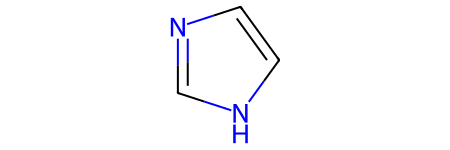

In [35]:
sub = Chem.MolFromSmiles('C1=CN=CN1')
# add_atom_numbers(sub)
sub

In [36]:
# Generate SMILES for substituents
# each element in the list is a tuple: (substituent, connecting atom index, bond type)

electron_withdrawing_substituents = [
    (Chem.MolFromSmiles('FC(F)F'), 1, rdchem.BondType.SINGLE),  # Trifluoromethyl
    (Chem.MolFromSmiles('Cl'), 0, rdchem.BondType.SINGLE),  # Chloro
    # (Chem.MolFromSmiles('F'), 0, rdchem.BondType.SINGLE),  # Fluoro
    (Chem.MolFromSmiles('I'), 0, rdchem.BondType.SINGLE),  # Iodo
    # (Chem.MolFromSmiles('Br'), 0, rdchem.BondType.SINGLE),  # Bromo
    (Chem.MolFromSmiles('C=O'), 0, rdchem.BondType.SINGLE),  # Carbonyl
    (Chem.MolFromSmiles('OC(=O)'), 1, rdchem.BondType.SINGLE),  # Carboxyl
    (Chem.MolFromSmiles('NC(=O)'), 1, rdchem.BondType.SINGLE),  # Amide
    (Chem.MolFromSmiles('C#N'), 0, rdchem.BondType.SINGLE),  # Cyano
    (Chem.MolFromSmiles('S(=O)(=O)O'), 0, rdchem.BondType.SINGLE),  # Sulfonic acid
    # (Chem.MolFromSmiles('[N+](=O)[O-]'), 0, rdchem.BondType.SINGLE),  # Nitro
]
extra_electron_withdrawing_substituents = [
    (Chem.MolFromSmiles('F'), 0, rdchem.BondType.SINGLE),  # Fluoro
    (Chem.MolFromSmiles('Br'), 0, rdchem.BondType.SINGLE),  # Bromo
    # (Chem.MolFromSmiles('[N+](=O)[O-]'), 0, rdchem.BondType.SINGLE),  # Nitro
    (Chem.MolFromSmiles('C1=CNN=C1'), 2, rdchem.BondType.SINGLE),  # Pyrazole
    
]
electron_donating_substituents = [
    (Chem.MolFromSmiles('N'), 0, rdchem.BondType.SINGLE),  # Amino
    (Chem.MolFromSmiles('CO'), 1, rdchem.BondType.SINGLE),  # Methoxy
    (Chem.MolFromSmiles('O'), 0, rdchem.BondType.SINGLE),  # Hydroxy
    (Chem.MolFromSmiles('C'), 0, rdchem.BondType.SINGLE),  # Methyl
    (Chem.MolFromSmiles('CN'), 0, rdchem.BondType.SINGLE),  # Methylamine
]

extra_electron_donating_substituents = [
    (Chem.MolFromSmiles('C1=CC=CC=C1'), 0, rdchem.BondType.SINGLE),  # Phenyl
    (Chem.MolFromSmiles('C1=COC=C1'), 0, rdchem.BondType.SINGLE),
    (Chem.MolFromSmiles('C1=CN=CN1'), 0, rdchem.BondType.SINGLE)
]
electron_donating_rings = [
    (Chem.MolFromSmiles('C1=CC=C2C(=C1)C=CS2'),
     0, rdchem.BondType.SINGLE),  # Benzothiophene
    (Chem.MolFromSmiles('C1=COC=C1'), 0, rdchem.BondType.SINGLE),  # Furan
    (Chem.MolFromSmiles('C1=CSC=C1'), 0, rdchem.BondType.SINGLE),  # Thiophene
    (Chem.MolFromSmiles('C1=CNC=C1'), 0, rdchem.BondType.SINGLE),  # Pyrrole
    (Chem.MolFromSmiles('C1=CN=CN1'), 0, rdchem.BondType.SINGLE),  # Imidazole
    (Chem.MolFromSmiles('C1=CON=C1'), 0, rdchem.BondType.SINGLE),  # Isoxazole
    # Methoxy-substituted thiophene
    (Chem.MolFromSmiles('COc1cccs1'), 5, rdchem.BondType.SINGLE),
    # Amino-substituted thiophene
    (Chem.MolFromSmiles('NCc1cccs1'), 5, rdchem.BondType.SINGLE),
    (Chem.MolFromSmiles('c1cc[nH]c1'), 2, rdchem.BondType.SINGLE),  # Pyrrole
    (Chem.MolFromSmiles('c1cc[nH]c1'), 1, rdchem.BondType.SINGLE),  # Pyrrole
    # Methyl-substituted pyrazole
    (Chem.MolFromSmiles('Cc1cc(C)[nH]n1'), 2, rdchem.BondType.SINGLE),
    # Methyl-substituted isoxazole
    (Chem.MolFromSmiles('c1cc(C)on1'), 2, rdchem.BondType.SINGLE),
]

electron_withdrawing_rings = [
    (Chem.MolFromSmiles('C1=CC=NC=C1'), 0, rdchem.BondType.SINGLE),  # Pyridine
    (Chem.MolFromSmiles('C1=CNN=C1'), 0, rdchem.BondType.SINGLE),  # Pyrazole
    (Chem.MolFromSmiles('c2ccc(n1cccn1)nc2'), 6, rdchem.BondType.SINGLE),  # Pyrazole with nitrogen substituted phenyl
    (Chem.MolFromSmiles('Oc2cccc(c1cc[nH]n1)c2'), 8, rdchem.BondType.SINGLE),  # Pyrazole with phenol
    (Chem.MolFromSmiles('c2ccc1n[nH]cc1c2'), 0, rdchem.BondType.SINGLE),  # Pyrazole extended with benzene
]

steric_blocking_substituents = [
    (Chem.MolFromSmiles('C(C)C'), 0, rdchem.BondType.SINGLE),  # Isopropyl
    (Chem.MolFromSmiles('C(C)(C)C'), 0, rdchem.BondType.SINGLE),  # Tert-butyl
    (Chem.MolFromSmiles('FC(F)F'), 1, rdchem.BondType.SINGLE),  # Trifluoromethyl
    (Chem.MolFromSmiles('I'), 0, rdchem.BondType.SINGLE),  # Iodo
]
# Validate substituent molecules
# invalid_substituent_EWG = validate_molecules(electron_withdrawing_substituents)
# print("Invalid EWG substituents:", invalid_substituent_EWG)
# 
# Validate substituent molecules
# invalid_substituent_EDG = validate_molecules(electron_donating_substituents)
# print("Invalid EDG substituents:", invalid_substituent_EDG)
# 
# Validate ring substituent molecules
# invalid_ring_sub_EDG = validate_molecules(electron_donating_rings)
# print("Invalid EDG rings:", invalid_ring_sub_EDG)
# 
# Validate ring substituent molecules
# invalid_ring_sub_EWG = validate_molecules(electron_withdrawing_rings)
# print("Invalid EWG rings:", invalid_ring_sub_EWG)

In [37]:
all_new_molecules = MoleculeSet()

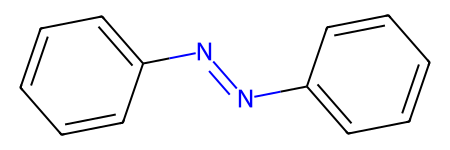

In [38]:
# Load the azobenzene structure
azobenzene = Chem.MolFromSmiles('C1=CC=C(C=C1)/N=N/C2=CC=CC=C2')
#add_atom_numbers(azobenzene)
azobenzene



In [39]:
# Generate azobenzene variations
azobenzene = Chem.MolFromSmiles('C1=CC=C(C=C1)/N=N/C2=CC=CC=C2')
all_positions = [0, 1, 2, 4, 5, 9, 10, 11, 12, 13]

ortho_positions = [2, 4, 9, 13]
meta_positions = [1, 5, 10, 12]
para_positions = [0, 11]

left_ring = [0, 1, 2, 4, 5]
left_ring_meta = [1, 5]
left_ring_ortho = [2, 4]
left_ring_para = [0]

right_ring = [9, 10, 11, 12, 13]
right_ring_meta = [10, 12]
right_ring_ortho = [9, 13]
right_ring_para = [11]

max_subs_para = 1
max_subs_ortho = 2
max_subs_meta = 2

logging.info('Generating push-pull azobenzene variations')

# Generate molecules with electron-donating substituents on the left ring
new_azobenzenes_meta = generate_and_print_molecules(
    azobenzene, electron_donating_substituents+extra_electron_donating_substituents, left_ring_meta, max_subs_meta, 'left', 'meta')
new_azobenzenes_para = generate_and_print_molecules(
    azobenzene, electron_donating_substituents+extra_electron_donating_substituents, left_ring_para, max_subs_para, 'left', 'para')

# Generate molecules with electron-withdrawing substituents on the right ring
for new_azobenzene in new_azobenzenes_meta:
    all_new_molecules.update_with_canonical_smiles(generate_and_print_molecules(
        new_azobenzene, electron_withdrawing_substituents+extra_electron_withdrawing_substituents, right_ring_meta, max_subs_meta, 'right', 'meta'))
    all_new_molecules.update_with_canonical_smiles(generate_and_print_molecules(
        new_azobenzene, electron_withdrawing_substituents+extra_electron_withdrawing_substituents, right_ring_para, max_subs_para, 'right', 'para'))

for new_azobenzene in new_azobenzenes_para:
    all_new_molecules.update_with_canonical_smiles(generate_and_print_molecules(
        new_azobenzene, electron_withdrawing_substituents+extra_electron_withdrawing_substituents, right_ring_meta, max_subs_meta, 'right', 'meta'))
    all_new_molecules.update_with_canonical_smiles(generate_and_print_molecules(
        new_azobenzene, electron_withdrawing_substituents+extra_electron_withdrawing_substituents, right_ring_para, max_subs_para, 'right', 'para'))
logging.info(
    f"Generated a total of {len(all_new_molecules)} new molecules.")
logging.info('Generating azobenzene variations that hinder ts')

# Add substituents that destabilize the z isomer
steric_azobenzenes = generate_and_print_molecules(
    azobenzene, steric_blocking_substituents, ortho_positions, max_subs_ortho, 'both', 'ortho')

for new_steric_azobenzene_right in steric_azobenzenes:
    more_steric_azobenzenes_right = generate_molecules(
        new_steric_azobenzene_right, electron_withdrawing_substituents+extra_electron_withdrawing_substituents, right_ring_para, 1)
    for new_azobenzene_left in more_steric_azobenzenes_right:
        more_steric_azobenzenes = generate_molecules(
            new_azobenzene_left, electron_donating_substituents+extra_electron_withdrawing_substituents, left_ring_para, 1)
        all_new_molecules.update_with_canonical_smiles(more_steric_azobenzenes)

logging.info(
    f"Generated a total of {len(all_new_molecules)} new molecules.")


INFO:root:Generating push-pull azobenzene variations


INFO:root:Generated a total of 4028 new molecules.
INFO:root:Generating azobenzene variations that hinder ts
INFO:root:Generated a total of 7253 new molecules.


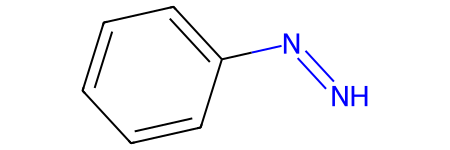

In [40]:
half_azobenzene = Chem.MolFromSmiles('C1=CC=C(C=C1)/N=N')
# add_atom_numbers(half_azobenzene)
half_azobenzene

In [41]:
# Generate half-azobenzene variations with the ring substituents
half_azobenzene = Chem.MolFromSmiles('C1=CC=C(C=C1)/N=N')
ring_sub_placement = [7]
ring_subs = electron_donating_rings + electron_withdrawing_rings

logging.info('Generating half-azobenzene variations with different rings')

half_azobenzenes_ring_subs = generate_molecules(
    half_azobenzene, ring_subs, ring_sub_placement, 1, min_subs=1)

# Expand each of the molecules with the ring substituent by adding up to three additional substituents at the sub placements
ring_positions = [0, 1, 2, 4, 5]
logging.info("Adding subs to the half-azobenzene variations")
# Generate molecules with electron-donating substituents
for mol in half_azobenzenes_ring_subs:
    all_new_molecules.update_with_canonical_smiles(generate_and_print_molecules(
        mol, electron_donating_substituents, left_ring_meta, 2, 'half-azobenzene', 'electron-donating meta'))
    new_ortho = generate_and_print_molecules(
        mol, electron_donating_substituents, left_ring_ortho, 2, 'half-azobenzene', 'electron-donating ortho')
    all_new_molecules.update_with_canonical_smiles(new_ortho)
    for ortho_mol in new_ortho:
        added_para = generate_and_print_molecules(
            mol, electron_donating_substituents, left_ring_para, 1, 'half-azobenzene', 'electron-donating para')
        all_new_molecules.update_with_canonical_smiles(added_para)
# Generate molecules with electron-withdrawing substituents
for mol in half_azobenzenes_ring_subs:
    all_new_molecules.update_with_canonical_smiles(generate_and_print_molecules(
        mol, electron_withdrawing_substituents, left_ring_meta, 2, 'half-azobenzene', 'electron-withdrawing meta'))
    new_ortho = generate_and_print_molecules(
        mol, electron_withdrawing_substituents, left_ring_ortho, 2, 'half-azobenzene', 'electron-withdrawing ortho')
    all_new_molecules.update_with_canonical_smiles(new_ortho)
    for ortho_mol in new_ortho:
        added_para = generate_and_print_molecules(
            mol, electron_withdrawing_substituents, left_ring_para, 1, 'half-azobenzene', 'electron-withdrawing para')
        all_new_molecules.update_with_canonical_smiles(added_para)

        
logging.info(
    f"Generated a total of {len(all_new_molecules)} new molecules.")

INFO:root:Generating half-azobenzene variations with different rings
INFO:root:Adding subs to the half-azobenzene variations
INFO:root:Generated a total of 9383 new molecules.


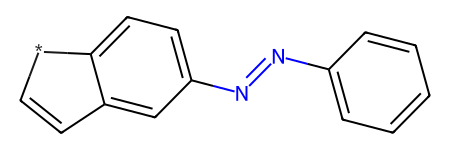

In [42]:
extened_azobenzene = Chem.MolFromSmiles("c1cc2cc(/N=N/c3ccccc3)ccc2*1")
# add_atom_numbers(extened_azobenzene)
extened_azobenzene

In [43]:
ortho = [12, 3, 13, 8]

right_posistions = [10, 12, 8]
right_para = [8]
right_meta = [11, 9]
left_posisitons = [1, 14]
left_para = [0]

# Example usage:
base_smiles = "c1cc2cc(/N=N/c3ccccc3)ccc2*1"
atom_list = ['S', 'O', 'N', 'C']
indices = [16]  # Indices of the atoms to replace (indices of '*' in the base_smiles)
new_extended_azos = replace_atoms(base_smiles, atom_list, indices)

In [44]:
index = 1
# Generate molecules with electron-donating substituents
for mol in new_extended_azos:
    logging.info(f"molecule {index}/{len(new_extended_azos)}")
    # Electron donating on left side
    with_subs_left = generate_and_print_molecules(
    mol, electron_donating_substituents, left_posisitons, 1, 'extended azobenzene left', 'electron-donating subs')
    all_new_molecules.update_with_canonical_smiles(with_subs_left)
                  
    # Generate molecules with electron-withdrawing substituents
    for left_subs_mol in with_subs_left:
        with_subs = generate_and_print_molecules(
            mol, electron_withdrawing_substituents, right_meta, 2, 'extended azobenzene right meta', 'electron-withdrawing subs')
    
        all_new_molecules.update_with_canonical_smiles(with_subs)

        with_subs_para = generate_and_print_molecules(
            mol, electron_withdrawing_substituents, right_para, 1, 'extended azobenzene right para', 'electron-withdrawing subs')
    
        all_new_molecules.update_with_canonical_smiles(with_subs_para)

    with_subs_left_ewg = generate_and_print_molecules(
    mol, electron_withdrawing_substituents, left_posisitons, 1, 'extended azobenzene', 'electron-withdrawing subs')
    all_new_molecules.update_with_canonical_smiles(with_subs_left_ewg)

    # Generate molecules with electron-donating substituents on right side
    for left_subs_mol in with_subs_left_ewg:
        with_subs = generate_and_print_molecules(
            mol, electron_donating_substituents, right_meta, 2, 'extended azobenzene right meta', 'electron-donating subs')
    
        all_new_molecules.update_with_canonical_smiles(with_subs)

        with_subs_para = generate_and_print_molecules(
            mol, electron_donating_substituents, right_para, 1, 'extended azobenzene right para', 'electron-donating subs')
    
        all_new_molecules.update_with_canonical_smiles(with_subs_para)
    logging.info(
    f"Generated a total of {len(all_new_molecules)} new molecules.")
    print("Adding ortho")
    # Add substituents that destabilize the z isomer
    steric_extended_azobenzenes = generate_and_print_molecules(
        mol, steric_blocking_substituents, ortho, 2, 'both', 'ortho')

    for new_steric_azobenzene_right in steric_extended_azobenzenes:
        more_steric_azobenzenes_right = generate_molecules(
            new_steric_azobenzene_right, electron_withdrawing_substituents, right_para, 1)
        for new_azobenzene_left in more_steric_azobenzenes_right:
            more_steric_azobenzenes = generate_molecules(
                new_azobenzene_left, electron_donating_substituents, left_para, 1)
            all_new_molecules.update_with_canonical_smiles(more_steric_azobenzenes)
            
    for new_steric_azobenzene_left in steric_extended_azobenzenes:
        more_steric_azobenzenes_left = generate_molecules(
            new_steric_azobenzene_left, electron_withdrawing_substituents, left_para, 1)
        for new_azobenzene_right in more_steric_azobenzenes_left:
            more_steric_azobenzenes = generate_molecules(
                new_azobenzene_right, electron_donating_substituents, right_para, 1)
            all_new_molecules.update_with_canonical_smiles(more_steric_azobenzenes)
            
    logging.info(
    f"Generated a total of {len(all_new_molecules)} new molecules.")
    index += 1

INFO:root:molecule 1/4


INFO:root:Generated a total of 9487 new molecules.


Adding ortho


INFO:root:Generated a total of 14214 new molecules.
INFO:root:molecule 2/4
INFO:root:Generated a total of 14318 new molecules.


Adding ortho


INFO:root:Generated a total of 19045 new molecules.
INFO:root:molecule 3/4
INFO:root:Generated a total of 19149 new molecules.


Adding ortho


INFO:root:Generated a total of 23876 new molecules.
INFO:root:molecule 4/4
INFO:root:Generated a total of 23980 new molecules.


Adding ortho


INFO:root:Generated a total of 28707 new molecules.


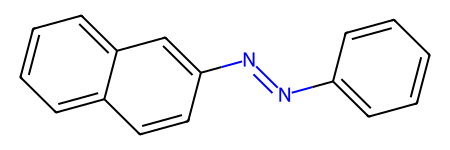

In [45]:
# Load the azobenzene structure
long_azobenzene = Chem.MolFromSmiles('c4ccc3cc(/N=N/c1ccccc1)ccc3c4')
# add_atom_numbers(long_azobenzene)
long_azobenzene

In [46]:
# Generate azobenzene variations
azobenzene = long_azobenzene

ortho_positions = [4, 14, 9, 13]
meta_positions = [2, 17, 10, 12]
para_positions = [0, 11]

left_ring = [0, 4, 18]
left_ring_meta = [2]
left_ring_ortho = [4, 14]
left_ring_para = [0]

right_ring = [10, 12, 13, 9]
right_ring_meta = [12, 10]
right_ring_ortho = [9, 13]
right_ring_para = [11]
max_subs_para = 1
max_subs_ortho = 2
max_subs_meta = 2

logging.info('Generating push-pull azobenzene variations')

# Generate molecules with electron-donating substituents on the left ring
long_azobenzenes_meta = generate_and_print_molecules(
    azobenzene, electron_donating_substituents, left_ring_meta, 1, 'left', 'meta')
long_azobenzenes_para = generate_and_print_molecules(
    azobenzene, electron_donating_substituents, left_ring_para, max_subs_para, 'left', 'para')

# Generate molecules with electron-withdrawing substituents on the right ring
for new_azobenzene in long_azobenzenes_meta:
    all_new_molecules.update_with_canonical_smiles(generate_and_print_molecules(
        new_azobenzene, electron_withdrawing_substituents, right_ring_meta, max_subs_meta, 'right', 'meta'))
    all_new_molecules.update_with_canonical_smiles(generate_and_print_molecules(
        new_azobenzene, electron_withdrawing_substituents, right_ring_para, max_subs_para, 'right', 'para'))

for new_azobenzene in long_azobenzenes_para:
    all_new_molecules.update_with_canonical_smiles(generate_and_print_molecules(
        new_azobenzene, electron_withdrawing_substituents, right_ring_meta, max_subs_meta, 'right', 'meta'))
    all_new_molecules.update_with_canonical_smiles(generate_and_print_molecules(
        new_azobenzene, electron_withdrawing_substituents, right_ring_para, max_subs_para, 'right', 'para'))
logging.info(
    f"Generated a total of {len(all_new_molecules)} new molecules.")
logging.info('Generating azobenzene variations that hinder ts')

# Add substituents that destabilize the z isomer
steric_long_azobenzenes = generate_and_print_molecules(
    azobenzene, steric_blocking_substituents, ortho_positions, max_subs_ortho, 'both', 'ortho')

for new_steric_azobenzene_right in steric_long_azobenzenes:
    more_steric_azobenzenes_right = generate_molecules(
        new_steric_azobenzene_right, electron_withdrawing_substituents, right_ring_para, 1)
    for new_azobenzene_left in more_steric_azobenzenes_right:
        more_steric_azobenzenes = generate_molecules(
            new_azobenzene_left, electron_donating_substituents, left_ring_para, 1)
        all_new_molecules.update_with_canonical_smiles(more_steric_azobenzenes)
logging.info(
    f"Generated a total of {len(all_new_molecules)} new molecules.")

INFO:root:Generating push-pull azobenzene variations
INFO:root:Generated a total of 29290 new molecules.
INFO:root:Generating azobenzene variations that hinder ts
INFO:root:Generated a total of 32098 new molecules.


In [47]:
input_df = pd.DataFrame(
    columns=['comp_name', 'smiles', 'charge', 'multiplicity'])

for smiles in tqdm(all_new_molecules.smiles()):
    comp_hash = get_hashed_label(smiles)
    comp_name = f"azo_{comp_hash}"
    charge = 0
    multiplicity = 1

    input_df = pd.concat([input_df, pd.DataFrame(
        [{'comp_name': comp_name, 'smiles': smiles, 'charge': charge, 'multiplicity': multiplicity}])], ignore_index=True)

# input_df['molecular_weight'] = input_df['smiles'].apply(
#     lambda x: Descriptors.MolWt(Chem.MolFromSmiles(x)))

32098it [01:05, 492.18it/s]


In [48]:
# save to csv
input_df.to_csv('molecules.csv', index=False)